In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin
import mlrose_hiive

In [2]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    y_pred = model.predict(X_test)
    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [3]:
def plot_learning_curve(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

def plot_validation_curve(clf, X_train, y_train, param_name, cv):
    # Define the hyperparameter range
    param_range = np.arange(1, 21)

    # Calculate training and validation scores over the specified hyperparameter range
    train_scores, test_scores = validation_curve(
        clf, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1
    )

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title('Model Complexity Graph')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [4]:
models = []
file_path = "Obfuscated-MalMem2022.csv"
data = pd.read_csv(file_path)
# data.head()
# data.describe().T
# data.info()
data.drop(['handles.nport', 'pslist.nprocs64bit', 'svcscan.interactive_process_services'], axis=1, inplace=True)
data = data.sample(n=40000, random_state=42)


data['Class'].replace({'Benign':0, 'Malware':1}, inplace=True)
data[['Cat1', 'Cat2']] = data['Category'].str.extract('(\w+)-(\w+)-.*', expand=True).fillna('Benign')
label_encoder = LabelEncoder()
data['Cat1'] = label_encoder.fit_transform(data['Cat1'])
data['Cat2'] = label_encoder.fit_transform(data['Cat2'])

# correlation_matrix = data.corr()
# plt.figure(figsize=(40,40))
# sns.heatmap(correlation_matrix, annot=True, center=0)

data.drop(['Category'], axis=1, inplace=True)

X=data.drop('Class',axis=1)
y=data['Class']

In [24]:
data.describe()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nfile,handles.nevent,...,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class,Cat1,Cat2
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,41.413925,14.656450,11.406217,249.555510,1820.241225,43.917232,1.034654e+04,251.704508,920.153175,3595.445925,...,25.996850,25.106075,116.917950,122.042675,86.96100,0.000500,7.999975,0.479950,0.897275,4.097800
std,5.893760,2.784927,1.608874,132.064045,333.709191,5.762711,5.700082e+03,174.247151,4137.202558,811.895808,...,0.152613,1.540952,1.523294,2.847834,3.01813,0.022355,0.005000,0.499604,1.047950,3.319904
min,21.000000,8.000000,1.650000,34.962500,670.000000,7.333333,3.514000e+03,71.139241,266.000000,966.000000,...,9.000000,7.000000,31.000000,34.000000,51.00000,0.000000,7.000000,0.000000,0.000000,0.000000
25%,40.000000,12.000000,9.976744,208.809524,1557.000000,38.783784,8.448000e+03,209.951220,647.000000,2927.000000,...,26.000000,24.000000,116.000000,121.000000,87.00000,0.000000,8.000000,0.000000,0.000000,2.000000
50%,41.000000,15.000000,11.136382,250.456333,1795.000000,43.736903,1.036600e+04,255.211393,852.000000,3556.000000,...,26.000000,24.000000,118.000000,123.000000,87.00000,0.000000,8.000000,0.000000,0.000000,2.000000
75%,43.000000,16.000000,12.910887,290.767412,2089.000000,49.625000,1.222000e+04,291.895178,1083.000000,4341.000000,...,26.000000,27.000000,118.000000,124.000000,88.00000,0.000000,8.000000,1.000000,2.000000,6.000000
max,240.000000,66.000000,16.818182,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,807008.000000,7885.000000,...,26.000000,27.000000,118.000000,129.000000,89.00000,1.000000,8.000000,1.000000,3.000000,12.000000


C:\Users\Abhishek.Agarwal\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


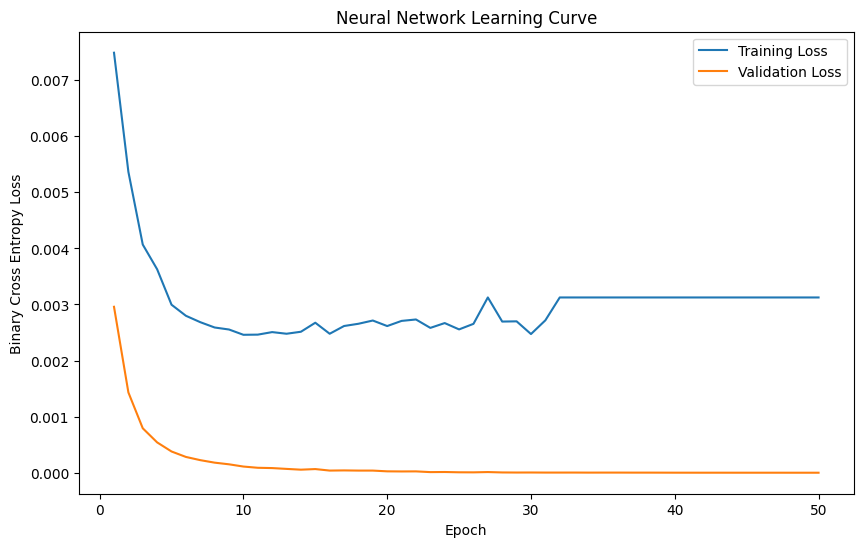

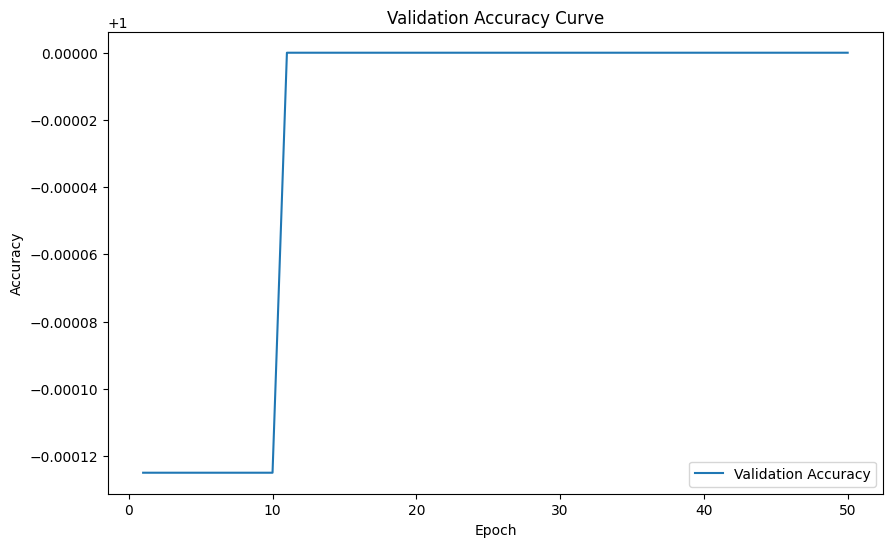

Accuracy on Test Set: 1.0000
F1 Score on Test Set: 1.0000
Total time taken : 42.13 seconds


In [5]:
import time
# Split the data into training and testing sets

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create a PyTorch TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the neural network model
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the neural network
epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()

    # Compute training loss
    model.eval()
    # with torch.no_grad():
    #     train_loss = criterion(model(X_train_tensor), y_train_tensor.view(-1, 1))
    #     train_losses.append(train_loss.item())
    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor.view(-1, 1))
        val_loss = criterion(model(X_test_tensor), y_test_tensor.view(-1, 1))

        val_preds = (model(X_test_tensor) > 0.5).float()
        val_accuracy = accuracy_score(y_test_tensor.numpy(), val_preds.numpy())

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

end_time = time.time()

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Neural Network Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy Loss')
plt.legend()
plt.show()


# Plot validation accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on the test set
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()


accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())
f1 = f1_score(y_test_tensor.numpy(), y_pred.numpy())

print(f"Accuracy on Test Set: {accuracy:.4f}")
print(f"F1 Score on Test Set: {f1:.4f}")

total_time = end_time - start_time
print(f"Total time taken : {total_time:.2f} seconds")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, fold, X, y, train_sizes=np.linspace(.05, 1.0, 12)):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=fold, n_jobs=-1, train_sizes=train_sizes)

    train_mins = train_scores.min(axis=1)
    train_avgs = train_scores.mean(axis=1)
    train_maxs = train_scores.max(axis=1)

    test_mins = test_scores.min(axis=1)
    test_avgs = test_scores.mean(axis=1)
    test_maxs = test_scores.max(axis=1)

    fig, ax = plt.subplots()
    ax.plot(train_sizes, train_avgs, label='Training Accuracy', color='indianred')
    ax.fill_between(train_sizes, train_mins, train_maxs, color='indianred', alpha=0.3)

    ax.plot(train_sizes, test_avgs, label='Validation Accuracy', color='mediumseagreen')
    ax.fill_between(train_sizes, test_mins, test_maxs, color='mediumseagreen', alpha=0.3)

    ax.set_xlabel('Training Size')
    ax.set_ylabel('Accuracy')
    ax.set_title('Learning Curves')
    ax.legend(loc='lower right')

    plt.show()



In [57]:
import time
import mlrose_hiive
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_neural_network(X_train, y_train, algorithm='gradient_descent', max_attempts=1000, max_iters=1000, learning_rate=0.001, random_state=None):

    neural_network = mlrose_hiive.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        algorithm=algorithm,
        max_attempts=max_attempts,
        max_iters=max_iters,
        bias=True,
        is_classifier=True,
        learning_rate=learning_rate,
        early_stopping=True,
        clip_max=5,
        schedule=mlrose_hiive.ExpDecay(),
        curve=True,
        random_state=random_state
    )

    start_time = time.time()
    neural_network.fit(X_train.values, y_train.values)
    end_time = time.time()
    training_time = end_time - start_time

    return neural_network, training_time

# Example usage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

neural_network, training_time = train_neural_network(X_train, y_train, random_state=42)

# Evaluate the model
y_train_pred = neural_network.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", accuracy)
y_test_pred = neural_network.predict(X_test_scaled)
testing_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", testing_accuracy)
gd_fitness_curve = neural_network.fitness_curve

plot_learning_curve(neural_network, 4, X_train, y_train)

Train Accuracy: 0.53471875
Test Accuracy: 0.533375


KeyboardInterrupt: 

In [6]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mlrose_hiive

def train_neural_network(X_train, y_train, algorithm='random_hill_climb', max_attempts=1000, max_iters=1000, learning_rate=0.01, random_state=None):
    neural_network = mlrose_hiive.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        algorithm=algorithm,
        max_attempts=max_attempts,
        max_iters=max_iters,
        bias=True,
        is_classifier=True,
        learning_rate=learning_rate,
        early_stopping=True,
        clip_max=5,
        schedule=mlrose_hiive.ExpDecay(),
        curve=True,
        random_state=random_state,
        restarts=10
    )

    start_time = time.time()
    neural_network.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    return neural_network, training_time

def evaluate_model(neural_network, X_test_scaled, X_train_scaled, y_test):
    y_pred = neural_network.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print("Train Accuracy:", accuracy)
    y_pred = neural_network.predict(X_test)
    training_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", training_accuracy)
    fitness_curve = neural_network.fitness_curve

    return accuracy, fitness_curve

# Example usage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the neural network
neural_network, training_time = train_neural_network(X_train_scaled, y_train, random_state=42)

# Evaluate the model
y_train_pred = neural_network.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", accuracy)
y_test_pred = neural_network.predict(X_test_scaled)
testing_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", testing_accuracy)
gd_fitness_curve = neural_network.fitness_curve

plot_learning_curve(neural_network, 4, X_train, y_train)


KeyboardInterrupt: 

0.569125


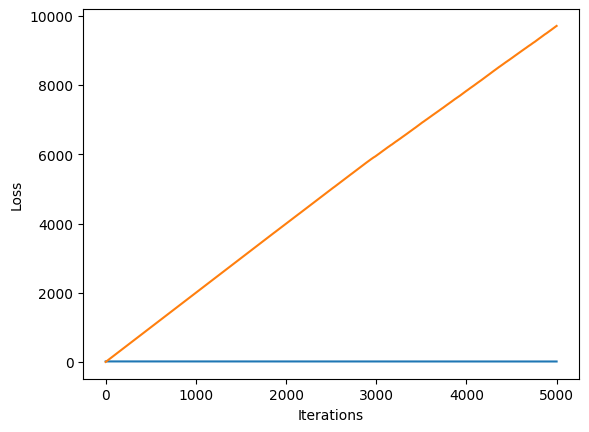

In [21]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mlrose_hiive

def train_neural_network(X_train, y_train, algorithm='simulated_annealing', max_attempts=1000, max_iters=1000, learning_rate=0.01, random_state=None):
    neural_network = mlrose_hiive.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        algorithm=algorithm,
        max_attempts=max_attempts,
        max_iters=max_iters,
        bias=True,
        is_classifier=True,
        learning_rate=learning_rate,
        early_stopping=True,
        clip_max=5,
        schedule=mlrose_hiive.ExpDecay(),
        curve=True,
        random_state=random_state,
    )

    start_time = time.time()
    neural_network.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    return neural_network, training_time

def evaluate_model(neural_network, X_test_scaled, X_train_scaled, y_test):
    y_pred = neural_network.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print("Train Accuracy:", accuracy)
    y_pred = neural_network.predict(X_test)
    training_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", training_accuracy)
    fitness_curve = neural_network.fitness_curve

    return accuracy, fitness_curve

# Example usage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the neural network
neural_network, training_time = train_neural_network(X_train_scaled, y_train, random_state=42)

# Evaluate the model
y_train_pred = neural_network.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", accuracy)
y_test_pred = neural_network.predict(X_test_scaled)
testing_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", testing_accuracy)
gd_fitness_curve = neural_network.fitness_curve

plot_learning_curve(neural_network, 4, X_train, y_train)


0.989125


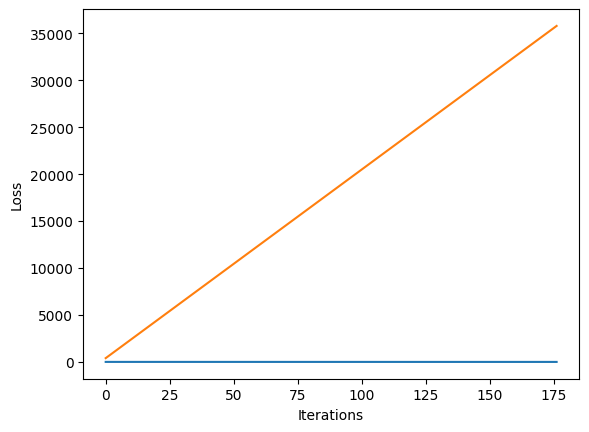

In [22]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mlrose_hiive

def train_neural_network(X_train, y_train, algorithm='genetic_alg', max_attempts=50, max_iters=5000, learning_rate=0.01, random_state=None):
    neural_network = mlrose_hiive.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        algorithm=algorithm,
        early_stopping=True,
        max_attempts=max_attempts,
        max_iters=max_iters,
        bias=True,
        learning_rate=learning_rate,
        clip_max=5,
        schedule=mlrose_hiive.ExpDecay(),
        restarts=0,
        curve=True,
        random_state=random_state
    )

    start_time = time.time()
    neural_network.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    return neural_network, training_time

def evaluate_model(neural_network, X_test, y_test):
    y_pred = neural_network.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fitness_curve = neural_network.fitness_curve

    return accuracy, fitness_curve

# Example usage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the neural network
neural_network, training_time = train_neural_network(X_train, y_train, random_state=42)

# Evaluate the model
accuracy, gd_fitness_curve = evaluate_model(neural_network, X_test, y_test)

print(accuracy)
plt.plot(gd_fitness_curve)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
